# Modélisation

Ingénierie des caractéristiques : Il s'agit de créer de nouvelles caractéristiques à partir des caractéristiques existantes par le biais de diverses transformations ou calculs. L'objectif est de fournir des données d'input de haut niveau qui peuvent aider le modèle à faire de meilleures prédictions.

Sélection des caractéristiques : Toutes les caractéristiques ne sont pas utiles. Certaines ne sont pas pertinentes et peuvent même diminuer les performances du modèle. Des techniques telles que l'élimination récursive des caractéristiques (RFE : Recursive Feature Elimination), SelectKBest ou l'utilisation de l'importance des caractéristiques à partir de modèles arborescents peuvent aider à sélectionner les caractéristiques les plus utiles.

Traitement des valeurs aberrantes : Votre valeur maximale pour "TotalGHGEmissions" est beaucoup plus grande que le 75e percentile, ce qui indique la présence possible de valeurs aberrantes. Les valeurs aberrantes peuvent avoir un impact significatif sur les performances de votre modèle. Vous pouvez étudier ces valeurs aberrantes et décider comment les traiter, par exemple en les supprimant ou en les plafonnant à une certaine valeur.

Réglage des hyperparamètres : Les modèles disposent de divers hyperparamètres qui peuvent être réglés pour améliorer les performances. Par exemple, dans le RandomForestRegressor, vous pouvez régler des paramètres tels que le nombre d'arbres (n_estimators), la profondeur maximale des arbres (max_depth) et le nombre minimal d'échantillons requis pour diviser un nœud interne (min_samples_split). Des techniques telles que GridSearchCV ou RandomizedSearchCV peuvent être utilisées pour le réglage des hyperparamètres.

Essayer différents modèles : Les différents modèles ont des forces et des faiblesses différentes, et il n'est souvent pas évident de déterminer celui qui fonctionnera le mieux sur vos données avant de l'avoir essayé. Envisagez d'essayer une variété de modèles de différentes catégories (par exemple, modèles linéaires, modèles à base d'arbres, réseaux neuronaux) pour voir lequel fonctionne le mieux sur vos données.

L'assemblage : Il s'agit de combiner les prédictions de plusieurs modèles. Le modèle combiné est souvent plus performant que n'importe quel modèle individuel, car il exploite les points forts de chacun d'eux. Les techniques utilisées sont le bagging, le boosting et le stacking.

Validation croisée : Cette technique consiste à diviser l'ensemble de données de formation en "k" plis, puis à former le modèle "k" fois, en utilisant à chaque fois un pli différent pour la validation et les plis restants pour la formation. Cela permet d'obtenir une estimation plus solide des performances du modèle.

## Imports

In [ ]:
import branca.colormap as cm
from category_encoders import TargetEncoder
import folium
from folium.plugins import MarkerCluster
from importlib import reload
import itertools
from math import sqrt
import matplotlib.pyplot as plt
from myfunctions import print_column, print_pca, print_anova_1f, print_chi2, print_corr_matrix
import numpy as np
import pandas as pd
import plotly.express as px
import random
import seaborn as sns

import scipy.stats as stats
from scipy.stats import chi2_contingency, normaltest, spearmanr

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFECV, SelectKBest, f_regression, RFE
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor 

import xgboost as xgb
from xgboost import XGBRegressor

In [6]:
final_data = pd.read_csv('2016_Building_Energy_Modelisation_Dataset.csv')
one_hot_df = pd.read_csv('2016_Building_Energy_Modelisation_OneHot.csv')

In [7]:
one_hot_df = one_hot_df.drop('Unnamed: 0', axis=1)

In [8]:
final_data = final_data.drop('Unnamed: 0', axis=1)

In [113]:
final_data.columns.tolist()

['OSEBuildingID',
 'DataYear',
 'BuildingType',
 'PrimaryPropertyType',
 'PropertyName',
 'Address',
 'City',
 'State',
 'ZipCode',
 'TaxParcelIdentificationNumber',
 'CouncilDistrictCode',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'YearsENERGYSTARCertified',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'DefaultData',
 'Comments',
 'ComplianceStatus',
 'Outlier',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'elecSurf

## Créaion de fonctions

In [4]:
def get_model_score(y_valid, preds):
    # Calculate metrics
    mae = mean_absolute_error(y_valid, preds) # Moyenne des erreurs (pas sensible aux fortes variations)
    mse = mean_squared_error(y_valid, preds)
    rmse = sqrt(mse) # Sensible aux fortes variations -> plus interprétable que MSE
    #rmsle = sqrt(mean_squared_error(np.log(y_valid), np.log(mean_preds))) # Transformation logarithmique qui facilite la représentation des erreurs si les valeurs sont très grandes

    r2 = r2_score(y_valid, preds) # Quelle proportion de la variance est expliquée ? (1 - RSE)
    # RSE (Relative Squared Error) : Rapport entre l'erreurs et la variance (RSS/DMSS)
    rss = np.sum(np.square(preds - y_valid))# RSS (Residual Squared Sum) : Total des erreurs au carré (sensible aux très fortes variations)
    # DMSS (Deviation to the Mean Squared Sum) : représente la variance
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'rss': rss}

In [5]:
def print_model_score(results_scores):
    
    print(f"MAE : {results_scores['mae']} | Moyenne des erreurs (pas sensible aux fortes variations) ")
    print(f"RMSE: {results_scores['rmse']} | racine des erreurs au carré (sensible aux fortes variations)")
    print(f"R² : {results_scores['r2']} | proportion de la variance expliquée")
    print(f"RSS : {results_scores['rss']} | Total des erreurs au carré (sensible aux très fortes variations)")

## Création de combinaisons de features

In [248]:
cat_cols = ['Neighborhood']
ord_cols = ['YearBuiltRange']
quali_cols = cat_cols + ord_cols
num_cols = ['NumberofBuildings', 'NumberofFloors', 'nbPropertyUseTypes']
oneHot_cols = one_hot_df.columns.tolist()
surf_cols = ['SecondLargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)']
star_cols = ['ENERGYSTARScore', 'nbEnergyStar']

qualiNum_cols = quali_cols + num_cols
qualiNumSurf_cols = qualiNum_cols + surf_cols
qualiNumOneHot_cols = qualiNum_cols + oneHot_cols
qualiNumSurfOneHot_cols = qualiNumSurf_cols + oneHot_cols

In [115]:
final_data[qualiNumSurfOneHot_cols]

,Neighborhood,YearBuiltRange,NumberofBuildings,NumberofFloors,nbPropertyUseTypes,SecondLargestPropertyUseTypeGFA,PropertyGFABuilding(s),Adult Education,Automobile Dealership,Bank Branch,...,Senior Care Community,Social/Meeting Hall,Strip Mall,Supermarket/Grocery Store,Swimming Pool,Urgent Care/Clinic/Other Outpatient,Vocational School,Wholesale Club/Supercenter,Worship Facility,others
0,DOWNTOWN,1920-1929,1.0,12,1,0.0,88434,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,DOWNTOWN,1990-1999,1.0,11,3,15064.0,88502,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,DOWNTOWN,1960-1969,1.0,41,1,0.0,759392,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,DOWNTOWN,1920-1929,1.0,10,1,0.0,61320,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,DOWNTOWN,1980-1989,1.0,18,3,68009.0,113580,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,GREATER DUWAMISH,1990-1999,1.0,1,1,0.0,12294,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1644,DOWNTOWN,2000-2009,1.0,1,1,0.0,16000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1645,MAGNOLIA / QUEEN ANNE,1970-1979,1.0,1,3,5574.0,13157,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1646,GREATER DUWAMISH,1980-1989,1.0,1,5,6501.0,14101,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036522


## Créaation de split des données pour chaque combinaisons de features et de variables à prédire

In [272]:
y_ghg = final_data['TotalGHGEmissions']
y_ghgSurf = final_data['GHGEmissionsIntensity']
y_energySurf = final_data['elecSurf']
y_energy = final_data['elec']

X_noOneHot = final_data[qualiNum_cols]
X_oneHotProcessed = final_data[qualiNumOneHot_cols] 
X_oneHotNotProcessed = final_data[qualiNumOneHot_cols]
X_surfNoOneHot = final_data[qualiNumSurf_cols]
X_surfOneHotProcessed = final_data[qualiNumSurfOneHot_cols] 
X_surfOneHotNotProcessed = final_data[qualiNumSurfOneHot_cols]
X_starOneHotProcessed = final_data[qualiNumOneHot_cols + star_cols]

ys = {'y_ghg': y_ghg, 'y_ghgSurf': y_ghgSurf, 'y_energy': y_energy, 'y_energySurf': y_energySurf}
Xs = {'X_oneHotNotProcessed': X_oneHotNotProcessed, 'X_oneHotProcessed': X_oneHotProcessed, 'X_noOneHot': X_noOneHot, 
      'X_surfOneHotNotProcessed': X_surfOneHotNotProcessed, 'X_surfOneHotProcessed': X_surfOneHotProcessed, 'X_surfNoOneHot': X_surfNoOneHot,}

In [273]:
splits = {}
names = ['_oneHotNotProcessed', '_oneHotProcessed', '_noOneHot', '_surfOneHotNotProcessed', '_surfOneHotProcessed', '_surfNoOneHot']
num_bins = 10

for y_key in ys:
    y = ys[y_key]
    i = 0
    y_categorical = pd.cut(y, bins=num_bins, labels=False)
    for X_key in Xs:
        if (y_key!='y_ghg' and y_key!='y_energy') and (X_key=='X_surfOneHotNotProcessed' or X_key=='X_surfOneHotProcessed' or X_key=='X_surfNoOneHot'):
            pass
        else:
            X = Xs[X_key]
            X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
            splits[y.name + names[i]] = {'X_train': X_train, 'X_valid': X_valid, 'y_train': y_train, 'y_valid': y_valid}
            i+=1
        
print(splits.keys())

dict_keys(['TotalGHGEmissions_oneHotNotProcessed', 'TotalGHGEmissions_oneHotProcessed', 'TotalGHGEmissions_noOneHot', 'TotalGHGEmissions_surfOneHotNotProcessed', 'TotalGHGEmissions_surfOneHotProcessed', 'TotalGHGEmissions_surfNoOneHot', 'GHGEmissionsIntensity_oneHotNotProcessed', 'GHGEmissionsIntensity_oneHotProcessed', 'GHGEmissionsIntensity_noOneHot', 'elec_oneHotNotProcessed', 'elec_oneHotProcessed', 'elec_noOneHot', 'elec_surfOneHotNotProcessed', 'elec_surfOneHotProcessed', 'elec_surfNoOneHot', 'elecSurf_oneHotNotProcessed', 'elecSurf_oneHotProcessed', 'elecSurf_noOneHot'])


## Imputateur et standardisation des variables

In [252]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

# Define preprocessing for categorical columns (impute them, then one-hot encode them)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Define preprocessing for ordinal columns (ordinal encode them)
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[final_data['YearBuiltRange'].unique()])),
])

### Preprocesseurs

In [253]:
preprocessor_oneHotProcessed = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols + oneHot_cols),
        ('cat', categorical_transformer, cat_cols),
        ('ord', ordinal_transformer, ord_cols)
    ])

preprocessor_oneHotNotProcessed = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
        ('ord', ordinal_transformer, ord_cols)
    ])

preprocessor_surfOneHotProcessed = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols + surf_cols + oneHot_cols),
        ('cat', categorical_transformer, cat_cols),
        ('ord', ordinal_transformer, ord_cols)
    ])

preprocessor_surfOneHotNotProcessed = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols + surf_cols),
        ('cat', categorical_transformer, cat_cols),
        ('ord', ordinal_transformer, ord_cols)
    ])

In [254]:
preprocessors = {
    'X_noOneHot': preprocessor_oneHotNotProcessed,
    'X_oneHotNotProcessed': preprocessor_oneHotNotProcessed,
    'X_oneHotProcessed': preprocessor_oneHotProcessed,
    'X_surfNoOneHot': preprocessor_surfOneHotNotProcessed,
    'X_surfOneHotNotProcessed': preprocessor_surfOneHotNotProcessed,
    'X_surfOneHotProcessed': preprocessor_surfOneHotProcessed,
    'X_starOneHotProcessed': preprocessor_oneHotProcessed,
}

In [122]:
# A quoi ressemblent les df après preprocess?

for key in splits.keys():
    split = splits[key]
    X_train, X_valid, y_train, y_valid = split['X_train'], split['X_valid'], split['y_train'], split['y_valid']
    preprocessor = "X_" + key.split('_')[1]
    
    # fit the pipeline to the training data
    preprocessors[preprocessor].fit(X_train)

    # apply the pipeline to the training and test data
    x_train_ = preprocessors[preprocessor].transform(X_train)
    x_valid_ = preprocessors[preprocessor].transform(X_valid)
    print("\n-------\n" + key)
    print(preprocessor)
    print(X_train.columns.tolist())
    print(pd.DataFrame(x_train_))


-------
TotalGHGEmissions_oneHotNotProcessed
X_oneHotNotProcessed
['Neighborhood', 'YearBuiltRange', 'NumberofBuildings', 'NumberofFloors', 'nbPropertyUseTypes', 'Adult Education', 'Automobile Dealership', 'Bank Branch', 'Bar/Nightclub', 'College/University', 'Convenience Store without Gas Station', 'Courthouse', 'Data Center', 'Distribution Center', 'Enclosed Mall', 'Fast Food Restaurant', 'Financial Office', 'Fire Station', 'Fitness Center/Health Club/Gym', 'Food Sales', 'Food Service', 'Hospital (General Medical & Surgical)', 'Hotel', 'K-12 School', 'Laboratory', 'Library', 'Lifestyle Center', 'Manufacturing/Industrial Plant', 'Medical Office', 'Movie Theater', 'Multifamily Housing', 'Museum', 'Non-Refrigerated Warehouse', 'Office', 'Other', 'Other - Education', 'Other - Entertainment/Public Assembly', 'Other - Lodging/Residential', 'Other - Mall', 'Other - Public Services', 'Other - Recreation', 'Other - Restaurant/Bar', 'Other - Services', 'Other - Technology/Science', 'Other - U


-------
GHGEmissionsIntensity_oneHotProcessed
X_oneHotProcessed
['Neighborhood', 'YearBuiltRange', 'NumberofBuildings', 'NumberofFloors', 'nbPropertyUseTypes', 'Adult Education', 'Automobile Dealership', 'Bank Branch', 'Bar/Nightclub', 'College/University', 'Convenience Store without Gas Station', 'Courthouse', 'Data Center', 'Distribution Center', 'Enclosed Mall', 'Fast Food Restaurant', 'Financial Office', 'Fire Station', 'Fitness Center/Health Club/Gym', 'Food Sales', 'Food Service', 'Hospital (General Medical & Surgical)', 'Hotel', 'K-12 School', 'Laboratory', 'Library', 'Lifestyle Center', 'Manufacturing/Industrial Plant', 'Medical Office', 'Movie Theater', 'Multifamily Housing', 'Museum', 'Non-Refrigerated Warehouse', 'Office', 'Other', 'Other - Education', 'Other - Entertainment/Public Assembly', 'Other - Lodging/Residential', 'Other - Mall', 'Other - Public Services', 'Other - Recreation', 'Other - Restaurant/Bar', 'Other - Services', 'Other - Technology/Science', 'Other - Uti


-------
elec_surfNoOneHot
X_surfNoOneHot
['Neighborhood', 'YearBuiltRange', 'NumberofBuildings', 'NumberofFloors', 'nbPropertyUseTypes', 'SecondLargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)']
            0         1         2         3         4    5    6    7    8   \
0    -0.109705 -0.483660 -0.753155 -0.361040 -0.379629  0.0  0.0  0.0  0.0   
1    -0.109705 -0.022287 -0.753155 -0.361040 -0.424263  0.0  0.0  0.0  0.0   
2    -0.109705 -0.329869 -0.753155 -0.361040 -0.349702  0.0  0.0  0.0  0.0   
3    -0.109705  0.131504  0.970210  2.616346  2.219034  0.0  0.0  0.0  0.0   
4    -0.109705 -0.329869 -0.753155 -0.361040  1.450719  0.0  0.0  1.0  0.0   
...        ...       ...       ...       ...       ...  ...  ...  ...  ...   
1313 -0.109705 -0.176078 -0.753155 -0.361040 -0.426218  0.0  1.0  0.0  0.0   
1314 -0.109705 -0.329869 -0.753155 -0.361040 -0.225047  0.0  0.0  0.0  0.0   
1315 -0.109705 -0.176078 -0.753155 -0.361040 -0.291787  0.0  0.0  0.0  0.0   
1316 -0.109705 -0.176

## Scores de référence

### Moyenne

In [123]:
result_dict = {}

for key in splits.keys():
    
    split = splits[key]
    X_train, X_valid, y_train, y_valid = split['X_train'], split['X_valid'], split['y_train'], split['y_valid']
    
    preds = len(y_valid)*[y_train.mean()]
    result_dict[key] = get_model_score(y_valid, preds)
    
    print("\n-------\n" + key)
    print_model_score(result_dict[key])


-------
TotalGHGEmissions_oneHotNotProcessed
MAE : 167.48787395962665 | Moyenne des erreurs (pas sensible aux fortes variations) 
RMSE: 292.7455023570908 | racine des erreurs au carré (sensible aux fortes variations)
R² : -0.059467312238517867 | proportion de la variance expliquée
RSS : 28280976.6196008 | Total des erreurs au carré (sensible aux très fortes variations)

-------
TotalGHGEmissions_oneHotProcessed
MAE : 171.63037108566698 | Moyenne des erreurs (pas sensible aux fortes variations) 
RMSE: 303.13685751156794 | racine des erreurs au carré (sensible aux fortes variations)
R² : -0.034991346331635365 | proportion de la variance expliquée
RSS : 30324344.946056258 | Total des erreurs au carré (sensible aux très fortes variations)

-------
TotalGHGEmissions_noOneHot
MAE : 158.58249165402125 | Moyenne des erreurs (pas sensible aux fortes variations) 
RMSE: 204.05073293162687 | racine des erreurs au carré (sensible aux fortes variations)
R² : -0.13921876754444273 | proportion de la 

### Aléatoire

In [124]:
result_dict = {}

for key in splits.keys():
    
    split = splits[key]
    X_train, X_valid, y_train, y_valid = split['X_train'], split['X_valid'], split['y_train'], split['y_valid']

    preds = [random.uniform(y_train.min(), y_train.max()) for _ in range(len(y_valid))]
    result_dict[key] = get_model_score(y_valid, preds)
    
    print("\n-------\n" + key)
    print_model_score(result_dict[key])


-------
TotalGHGEmissions_oneHotNotProcessed
MAE : 8132.763946622191 | Moyenne des erreurs (pas sensible aux fortes variations) 
RMSE: 9429.807675216067 | racine des erreurs au carré (sensible aux fortes variations)
R² : -1098.2912458547862 | proportion de la variance expliquée
RSS : 29344020021.21607 | Total des erreurs au carré (sensible aux très fortes variations)

-------
TotalGHGEmissions_oneHotProcessed
MAE : 8180.43809996536 | Moyenne des erreurs (pas sensible aux fortes variations) 
RMSE: 9594.264523183689 | racine des erreurs au carré (sensible aux fortes variations)
R² : -1035.770441145545 | proportion de la variance expliquée
RSS : 30376470874.470978 | Total des erreurs au carré (sensible aux très fortes variations)

-------
TotalGHGEmissions_noOneHot
MAE : 8176.500652803774 | Moyenne des erreurs (pas sensible aux fortes variations) 
RMSE: 9518.759877887576 | racine des erreurs au carré (sensible aux fortes variations)
R² : -2478.0857873650316 | proportion de la variance ex

## Premier modèle : regression linéaire avec TotalGHGEmissions

In [270]:
splits['TotalGHGEmissions_surfOneHotNotProcessed'].keys()

dict_keys(['X_train', 'X_valid', 'y_train', 'y_valid'])

In [159]:
split = splits['TotalGHGEmissions_surfOneHotNotProcessed']

In [160]:
X_train, X_valid, y_train, y_valid = split['X_train'], split['X_valid'], split['y_train'], split['y_valid']

In [161]:
clf = Pipeline(steps=[('preprocessor', preprocessor_surfOneHotNotProcessed),
                          #('feature_selection', rfe),
                          ('model', LinearRegression())
                         ])

In [162]:
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)
results = get_model_score(y_valid, preds)

print_model_score(results)

MAE : 205.02216535312684 | Moyenne des erreurs (pas sensible aux fortes variations) 
RMSE: 481.8026180940817 | racine des erreurs au carré (sensible aux fortes variations)
R² : 0.09836597408610637 | proportion de la variance expliquée
RSS : 76604141.72476281 | Total des erreurs au carré (sensible aux très fortes variations)


#### Amélioration avec 5 splits

In [129]:
# Perform 5-fold cross-validation for each scoring metric
mae_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=mae_scorer)
rmse_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=rmse_scorer)
rss_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=rss_scorer)
r2_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=r2_scorer)

# Print the mean score and the score for each split for each metric
for metric, scores in zip(['MAE', 'RMSE', 'RSS', 'R^2'], [mae_scores, rmse_scores, rss_scores, r2_scores]):
    if metric == 'R^2':
        print(f"\n{metric} mean score: {scores.mean():.2f}")
    else:
        print(f"\n{metric} mean score: {-scores.mean():.2f}")
    print(f"{metric} scores for each split:")
    for i, score in enumerate(scores):
        if metric == 'R^2':
            print(f"Split {i+1}: {score:.2f}")
        else:
            print(f"Split {i+1}: {-score:.2f}")


MAE mean score: 220.85
MAE scores for each split:
Split 1: 187.64
Split 2: 210.96
Split 3: 262.47
Split 4: 216.30
Split 5: 226.87

RMSE mean score: 641.12
RMSE scores for each split:
Split 1: 569.48
Split 2: 557.42
Split 3: 1078.45
Split 4: 497.82
Split 5: 502.45

RSS mean score: 459672.75
RSS scores for each split:
Split 1: 324306.17
Split 2: 310718.91
Split 3: 1163060.89
Split 4: 247821.70
Split 5: 252456.09

R^2 mean score: -0.89
R^2 scores for each split:
Split 1: 0.48
Split 2: 0.47
Split 3: 0.15
Split 4: -0.48
Split 5: -5.08


#### Choix des paramètres

In [163]:
# Définir la grille de paramètres à tester
# param_grid = {'preprocessor__some_param': [values], 'feature_selection__some_param': [values]}
param_grid = {
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]
}

# Définissez GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5,
                           scoring={'mae': mae_scorer,
                                    'rmse': rmse_scorer,
                                    'rss': rss_scorer,
                                    'r2': r2_scorer},
                           refit='r2')

# Ajustez le modèle
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", grid_search.best_params_)

# Calculer les 4 scores pour les meilleurs paramètres sur le jeu de validation
y_pred = grid_search.best_estimator_.predict(X_valid)
mae_pred_score = mean_absolute_error(y_valid, y_pred)
rmse_pred_score = mean_squared_error(y_valid, y_pred, squared=False)
rss_pred_score = mean_squared_error(y_valid, y_pred)
r2_pred_score = r2_score(y_valid, y_pred)

# Afficher les 4 scores pour les meilleurs paramètres
print("\nMAE mean score : {:.2f}".format(mae_pred_score))
print("RMSE mean score : {:.2f}".format(rmse_pred_score))
print("RSS mean score : {:.2f}".format(rss_pred_score))
print("R^2 mean score : {:.2f}".format(r2_pred_score))

Meilleurs paramètres :  {'model__fit_intercept': True, 'model__positive': True}

MAE mean score : 191.21
RMSE mean score : 458.97
RSS mean score : 210649.25
R^2 mean score : 0.18


#### Test avec les nouveaux paramètres

In [173]:
clf = Pipeline(steps=[('preprocessor', preprocessor_surfOneHotNotProcessed),
                          #('feature_selection', rfe),
                          ('model', LinearRegression(fit_intercept=True, positive=True))
                         ])

In [174]:
# Perform 5-fold cross-validation for each scoring metric
mae_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=mae_scorer)
rmse_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=rmse_scorer)
rss_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=rss_scorer)
r2_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=r2_scorer)

# Print the mean score and the score for each split for each metric
for metric, scores in zip(['MAE', 'RMSE', 'RSS', 'R^2'], [mae_scores, rmse_scores, rss_scores, r2_scores]):
    if metric == 'R^2':
        print(f"\n{metric} mean score: {scores.mean():.2f}")
    else:
        print(f"\n{metric} mean score: {-scores.mean():.2f}")
    print(f"{metric} scores for each split:")
    for i, score in enumerate(scores):
        if metric == 'R^2':
            print(f"Split {i+1}: {score:.2f}")
        else:
            print(f"Split {i+1}: {-score:.2f}")



MAE mean score: 218.80
MAE scores for each split:
Split 1: 195.87
Split 2: 223.48
Split 3: 258.31
Split 4: 210.63
Split 5: 205.69

RMSE mean score: 648.01
RMSE scores for each split:
Split 1: 612.09
Split 2: 598.99
Split 3: 1101.98
Split 4: 476.56
Split 5: 450.42

RSS mean score: 475556.53
RSS scores for each split:
Split 1: 374648.56
Split 2: 358791.61
Split 3: 1214351.60
Split 4: 227109.56
Split 5: 202881.35

R^2 mean score: -0.67
R^2 scores for each split:
Split 1: 0.40
Split 2: 0.38
Split 3: 0.11
Split 4: -0.35
Split 5: -3.88


## Choix d'un modèle, des features et d'un preprocesseur

In [175]:
for y_key in ys:
    y = ys[y_key]
    
    for X_key in Xs:
        X = Xs[X_key]
        
        if y_key!='y_total' and (X_key=='X_surfOneHotNotProcessed' or X_key=='X_surfOneHotProcessed' or X_key=='X_surfNoOneHot'):
            pass
        else:
            
            for strat in ['notStratified', 'stratified']:

                print(f"\ny = {y_key}")
                print(f"X = {X_key}")
                print(f"Splits : {strat}")

                selected_preprocessor = preprocessors.get(X_key)

                # Define the Pipeline with the ColumnTransformer and the model
                pipeline = Pipeline([
                    ('preprocessor', selected_preprocessor ),
                    ('regressor', LinearRegression())  # Placeholder for the model
                ])

                # Define the parameter grid for the models
                param_grid = {
                    'regressor': [LinearRegression(), Ridge(), Lasso(), ElasticNet(), XGBRegressor(), DecisionTreeRegressor(), RandomForestRegressor()]
                    #'regressor__alpha': [0.5, 1, 1.5] # Add hyperparameters for each model
                }

                # Perform cross-validated grid search
                kf = KFold(n_splits=5, shuffle=True, random_state=18)  
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=18) # Use StratifiedKFold for stratified k-fold
                cv = kf if strat=='notStratified' else skf

                y_cat = pd.cut(y, bins=10, labels=False)
                y = y if strat=='notStratified' else y_cat

                grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='r2', n_jobs=-1)  # Use 'r2' as the scoring metric

                # Fit the grid search to the data
                grid_search.fit(X, y)

                # Get the best model and its r2 score
                best_model = grid_search.best_estimator_.get_params()['regressor']
                regressor_params = {k: v for k, v in grid_search.best_estimator_.get_params().items() if k.startswith('regressor__')}
                best_score = grid_search.best_score_            

                print(f'\nMeilleur modèle : {str(best_model)}')
                print(regressor_params)
                print(f'\nR2 = {best_score}')
                print('\n------')


y = y_ghg
X = X_oneHotNotProcessed
Splits : notStratified

Meilleur modèle : Lasso()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': 1000, 'regressor__positive': False, 'regressor__precompute': False, 'regressor__random_state': None, 'regressor__selection': 'cyclic', 'regressor__tol': 0.0001, 'regressor__warm_start': False}

R2 = 0.09487350980253047

------

y = y_ghg
X = X_oneHotNotProcessed
Splits : stratified


C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Meilleur modèle : RandomForestRegressor()
{'regressor__bootstrap': True, 'regressor__ccp_alpha': 0.0, 'regressor__criterion': 'squared_error', 'regressor__max_depth': None, 'regressor__max_features': 1.0, 'regressor__max_leaf_nodes': None, 'regressor__max_samples': None, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__min_weight_fraction_leaf': 0.0, 'regressor__n_estimators': 100, 'regressor__n_jobs': None, 'regressor__oob_score': False, 'regressor__random_state': None, 'regressor__verbose': 0, 'regressor__warm_start': False}

R2 = 0.07110850971372466

------

y = y_ghg
X = X_oneHotProcessed
Splits : notStratified

Meilleur modèle : Lasso()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': 1000, 'regressor__positive': False, 'regressor__precompute': False, 'regressor__random_state': None, 'regressor__selection': 'cyclic', 'regressor__tol': 0.0001, 'regr

C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Meilleur modèle : Lasso()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': 1000, 'regressor__positive': False, 'regressor__precompute': False, 'regressor__random_state': None, 'regressor__selection': 'cyclic', 'regressor__tol': 0.0001, 'regressor__warm_start': False}

R2 = -0.006513472948064303

------

y = y_ghg
X = X_noOneHot
Splits : notStratified

Meilleur modèle : Ridge()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': None, 'regressor__positive': False, 'regressor__random_state': None, 'regressor__solver': 'auto', 'regressor__tol': 0.0001}

R2 = 0.048583333988391694

------

y = y_ghg
X = X_noOneHot
Splits : stratified


C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Meilleur modèle : RandomForestRegressor()
{'regressor__bootstrap': True, 'regressor__ccp_alpha': 0.0, 'regressor__criterion': 'squared_error', 'regressor__max_depth': None, 'regressor__max_features': 1.0, 'regressor__max_leaf_nodes': None, 'regressor__max_samples': None, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__min_weight_fraction_leaf': 0.0, 'regressor__n_estimators': 100, 'regressor__n_jobs': None, 'regressor__oob_score': False, 'regressor__random_state': None, 'regressor__verbose': 0, 'regressor__warm_start': False}

R2 = 0.012321963877365593

------

y = y_ghgSurf
X = X_oneHotNotProcessed
Splits : notStratified

Meilleur modèle : Ridge()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': None, 'regressor__positive': False, 'regressor__random_state': None, 'regressor__solver': 'auto', 'regressor__tol': 0.0001}

R2 = 0.007755634399549805

------

C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Meilleur modèle : Ridge()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': None, 'regressor__positive': False, 'regressor__random_state': None, 'regressor__solver': 'auto', 'regressor__tol': 0.0001}

R2 = 0.006580501376954806

------

y = y_ghgSurf
X = X_oneHotProcessed
Splits : notStratified

Meilleur modèle : RandomForestRegressor()
{'regressor__bootstrap': True, 'regressor__ccp_alpha': 0.0, 'regressor__criterion': 'squared_error', 'regressor__max_depth': None, 'regressor__max_features': 1.0, 'regressor__max_leaf_nodes': None, 'regressor__max_samples': None, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__min_weight_fraction_leaf': 0.0, 'regressor__n_estimators': 100, 'regressor__n_jobs': None, 'regressor__oob_score': False, 'regressor__random_state': None, 'regressor__verbose': 0, 'regressor__warm_start': False}

R2 = 0.20498257910497902

------

y 

C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Meilleur modèle : RandomForestRegressor()
{'regressor__bootstrap': True, 'regressor__ccp_alpha': 0.0, 'regressor__criterion': 'squared_error', 'regressor__max_depth': None, 'regressor__max_features': 1.0, 'regressor__max_leaf_nodes': None, 'regressor__max_samples': None, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__min_weight_fraction_leaf': 0.0, 'regressor__n_estimators': 100, 'regressor__n_jobs': None, 'regressor__oob_score': False, 'regressor__random_state': None, 'regressor__verbose': 0, 'regressor__warm_start': False}

R2 = 0.214970097496075

------

y = y_ghgSurf
X = X_noOneHot
Splits : notStratified

Meilleur modèle : Lasso()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': 1000, 'regressor__positive': False, 'regressor__precompute': False, 'regressor__random_state': None, 'regressor__selection': 'cyclic', 'regressor__tol': 0.0001, 'regressor

C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Meilleur modèle : Ridge()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': None, 'regressor__positive': False, 'regressor__random_state': None, 'regressor__solver': 'auto', 'regressor__tol': 0.0001}

R2 = 0.006580501376954806

------

y = y_energy
X = X_oneHotNotProcessed
Splits : notStratified

Meilleur modèle : Ridge()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': None, 'regressor__positive': False, 'regressor__random_state': None, 'regressor__solver': 'auto', 'regressor__tol': 0.0001}

R2 = 0.19877085176551493

------

y = y_energy
X = X_oneHotNotProcessed
Splits : stratified


C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Meilleur modèle : Ridge()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': None, 'regressor__positive': False, 'regressor__random_state': None, 'regressor__solver': 'auto', 'regressor__tol': 0.0001}

R2 = 0.07252131720015109

------

y = y_energy
X = X_oneHotProcessed
Splits : notStratified

Meilleur modèle : Lasso()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': 1000, 'regressor__positive': False, 'regressor__precompute': False, 'regressor__random_state': None, 'regressor__selection': 'cyclic', 'regressor__tol': 0.0001, 'regressor__warm_start': False}

R2 = -0.006439707362909175

------

y = y_energy
X = X_oneHotProcessed
Splits : stratified


C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Meilleur modèle : DecisionTreeRegressor()
{'regressor__ccp_alpha': 0.0, 'regressor__criterion': 'squared_error', 'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__max_leaf_nodes': None, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__min_weight_fraction_leaf': 0.0, 'regressor__random_state': None, 'regressor__splitter': 'best'}

R2 = 0.07847436320782342

------

y = y_energy
X = X_noOneHot
Splits : notStratified

Meilleur modèle : Ridge()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': None, 'regressor__positive': False, 'regressor__random_state': None, 'regressor__solver': 'auto', 'regressor__tol': 0.0001}

R2 = 0.08374367649512227

------

y = y_energy
X = X_noOneHot
Splits : stratified


C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Meilleur modèle : Ridge()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': None, 'regressor__positive': False, 'regressor__random_state': None, 'regressor__solver': 'auto', 'regressor__tol': 0.0001}

R2 = 0.07252131720015109

------

y = y_energySurf
X = X_oneHotNotProcessed
Splits : notStratified

Meilleur modèle : Lasso()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': 1000, 'regressor__positive': False, 'regressor__precompute': False, 'regressor__random_state': None, 'regressor__selection': 'cyclic', 'regressor__tol': 0.0001, 'regressor__warm_start': False}

R2 = 0.022601934962592662

------

y = y_energySurf
X = X_oneHotNotProcessed
Splits : stratified


C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Meilleur modèle : Ridge()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': None, 'regressor__positive': False, 'regressor__random_state': None, 'regressor__solver': 'auto', 'regressor__tol': 0.0001}

R2 = 0.0071707437113867735

------

y = y_energySurf
X = X_oneHotProcessed
Splits : notStratified

Meilleur modèle : RandomForestRegressor()
{'regressor__bootstrap': True, 'regressor__ccp_alpha': 0.0, 'regressor__criterion': 'squared_error', 'regressor__max_depth': None, 'regressor__max_features': 1.0, 'regressor__max_leaf_nodes': None, 'regressor__max_samples': None, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__min_weight_fraction_leaf': 0.0, 'regressor__n_estimators': 100, 'regressor__n_jobs': None, 'regressor__oob_score': False, 'regressor__random_state': None, 'regressor__verbose': 0, 'regressor__warm_start': False}

R2 = 0.3700798269382676

------


C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Meilleur modèle : RandomForestRegressor()
{'regressor__bootstrap': True, 'regressor__ccp_alpha': 0.0, 'regressor__criterion': 'squared_error', 'regressor__max_depth': None, 'regressor__max_features': 1.0, 'regressor__max_leaf_nodes': None, 'regressor__max_samples': None, 'regressor__min_impurity_decrease': 0.0, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__min_weight_fraction_leaf': 0.0, 'regressor__n_estimators': 100, 'regressor__n_jobs': None, 'regressor__oob_score': False, 'regressor__random_state': None, 'regressor__verbose': 0, 'regressor__warm_start': False}

R2 = 0.3897473579986146

------

y = y_energySurf
X = X_noOneHot
Splits : notStratified

Meilleur modèle : Ridge()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': None, 'regressor__positive': False, 'regressor__random_state': None, 'regressor__solver': 'auto', 'regressor__tol': 0.0001}

R2 = 0.008391499794625657

------

y = y_e

C:\Users\Z478SG\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Meilleur modèle : Ridge()
{'regressor__alpha': 1.0, 'regressor__copy_X': True, 'regressor__fit_intercept': True, 'regressor__max_iter': None, 'regressor__positive': False, 'regressor__random_state': None, 'regressor__solver': 'auto', 'regressor__tol': 0.0001}

R2 = 0.0071707437113867735

------


In [178]:
split = splits['elecSurf_oneHotProcessed']

On choisi une Random Forest Regressor, avec y = ElecSurf, X = nums + cat + one hot processé (pas de surfaces)

## Random Forest Regressor

In [185]:
X_train, y_train, X_valid, y_valid = split['X_train'], split['y_train'], split['X_valid'], split['y_valid']

In [186]:
clf = Pipeline(steps=[('preprocessor', preprocessor_oneHotProcessed),
                      ('model', RandomForestRegressor()) 
                     ])

In [187]:
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
randfor_preds = clf.predict(X_valid)

results = get_model_score(y_valid, randfor_preds)
print_model_score(results)

MAE : 35.274718602850285 | Moyenne des erreurs (pas sensible aux fortes variations) 
RMSE: 58.41890545867105 | racine des erreurs au carré (sensible aux fortes variations)
R² : 0.28030053164090263 | proportion de la variance expliquée
RSS : 1126213.6099464183 | Total des erreurs au carré (sensible aux très fortes variations)


#### Amélioration avec k-fold

In [188]:
# Perform 5-fold cross-validation for each scoring metric
mae_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=mae_scorer)
rmse_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=rmse_scorer)
rss_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=rss_scorer)
r2_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=r2_scorer)

# Print the mean score and the score for each split for each metric
for metric, scores in zip(['MAE', 'RMSE', 'RSS', 'R^2'], [mae_scores, rmse_scores, rss_scores, r2_scores]):
    if metric == 'R^2':
        print(f"\n{metric} mean score: {scores.mean():.2f}")
    else:
        print(f"\n{metric} mean score: {-scores.mean():.2f}")
    print(f"{metric} scores for each split:")
    for i, score in enumerate(scores):
        if metric == 'R^2':
            print(f"Split {i+1}: {score:.2f}")
        else:
            print(f"Split {i+1}: {-score:.2f}")



MAE mean score: 31.73
MAE scores for each split:
Split 1: 31.83
Split 2: 26.15
Split 3: 34.25
Split 4: 29.58
Split 5: 36.82

RMSE mean score: 53.99
RMSE scores for each split:
Split 1: 51.69
Split 2: 38.49
Split 3: 61.46
Split 4: 46.19
Split 5: 72.14

RSS mean score: 2995.75
RSS scores for each split:
Split 1: 2589.08
Split 2: 1516.23
Split 3: 3630.85
Split 4: 2149.66
Split 5: 5092.90

R^2 mean score: 0.48
R^2 scores for each split:
Split 1: 0.46
Split 2: 0.57
Split 3: 0.43
Split 4: 0.56
Split 5: 0.39


#### Sélection des paramètres

In [224]:
kfold = KFold(n_splits=5, shuffle=True, random_state=18)

grid_param = {
    'model__n_estimators': [50],    # 50, pas très important ; [10, 50, 100, 500]
    'model__criterion': ['absolute_error'], # absolute_error ; ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'model__max_depth': [None], # None, pas très important  ; Entiers positifs, souvent entre 5 et 100, ou None
    'model__min_samples_split': [20], # Entiers positifs, souvent entre 2 et 20
    'model__min_weight_fraction_leaf':[0], # [0, 0.5]
    #'model__min_samples_leaf': [2, 4, 6, 8, 10], # Entier positif, souvent entre 1 et 10
    'model__max_features': [20], # Nombre de features, entre 1 et max features dans le tableau
    'model__bootstrap': [True, False] # [True, False], 
    }

grid_search = GridSearchCV(clf, grid_param, cv=kfold, scoring='r2')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
cv_results = [v for k, v in grid_search.cv_results_.items() if k.startswith('split')]

print(f"Meilleurs paramètres : {best_params}")
print(f"Score avec ces paramètres {best_score}")
print(f"Détails des scores :\n{cv_results}")

Meilleurs paramètres : {'model__bootstrap': False, 'model__criterion': 'absolute_error', 'model__max_depth': None, 'model__max_features': 20, 'model__min_samples_split': 20, 'model__min_weight_fraction_leaf': 0, 'model__n_estimators': 50}
Score avec ces paramètres 0.4544150116450781
Détails des scores :
[array([0.5389386 , 0.46277409]), array([0.30697408, 0.26314744]), array([0.6007911 , 0.62384321]), array([0.39876064, 0.4004394 ]), array([0.41899584, 0.52187092])]


#### Modèle final

In [231]:
clf = Pipeline(steps=[('preprocessor', preprocessor_oneHotProcessed),
                      #('feature_selection', rfe),
                      ('model', RandomForestRegressor(bootstrap=False, 
                                                     n_estimators=50, 
                                                     criterion='absolute_error', 
                                                     max_depth=None,
                                                     max_features=20,
                                                     min_samples_split=20,
                                                      min_weight_fraction_leaf=0,
                                                     ))
                     ])

clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
randfor_preds = clf.predict(X_valid)
# print(pd.DataFrame(y_valid, pred))
results = get_model_score(y_valid, randfor_preds)
print_model_score(results)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'nbPropertyUseTypes',
                                                   'Adult Education',
                                                   'Automobile Dealership',
                                                   'Bank Branch',
                                                   'Bar/Nightclub',
                                                   'College/University',
                                                   'Convenience Store without '
                                                   'Gas Station',
                                                   'Courthouse', 'Data...
                                                                   OrdinalEncoder(categories=[array(['1920-1929', '1990-1999', '1960-1969', '1980-1989', '1900-1909',
       '2000-2009', '1930-1939', '1910-1919', '1950-1959', '1970-1979',
       '1940-1949', '2010-2019'], dtype=object)]))]),
                                                  ['YearBuiltRange'])])),
                ('model',
                 RandomForestRegressor(bootstrap=False,
                                       criterion='absolute_error',
                                       max_features=20, min_samples_split=20,
                                       min_weight_fraction_leaf=0,
                                       n_estimators=50))])

In [232]:
# Perform 5-fold cross-validation for each scoring metric
mae_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=mae_scorer)
rmse_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=rmse_scorer)
rss_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=rss_scorer)
r2_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=r2_scorer)

# Print the mean score and the score for each split for each metric
for metric, scores in zip(['MAE', 'RMSE', 'RSS', 'R^2'], [mae_scores, rmse_scores, rss_scores, r2_scores]):
    if metric == 'R^2':
        print(f"\n{metric} mean score: {scores.mean():.2f}")
    else:
        print(f"\n{metric} mean score: {-scores.mean():.2f}")
    print(f"{metric} scores for each split:")
    for i, score in enumerate(scores):
        if metric == 'R^2':
            print(f"Split {i+1}: {score:.2f}")
        else:
            print(f"Split {i+1}: {-score:.2f}")


MAE mean score: 30.70
MAE scores for each split:
Split 1: 28.62
Split 2: 25.33
Split 3: 34.85
Split 4: 29.32
Split 5: 35.36

RMSE mean score: 53.10
RMSE scores for each split:
Split 1: 45.68
Split 2: 40.20
Split 3: 63.39
Split 4: 45.80
Split 5: 70.41

RSS mean score: 2939.94
RSS scores for each split:
Split 1: 2112.74
Split 2: 1616.85
Split 3: 3819.21
Split 4: 2128.48
Split 5: 5022.41

R^2 mean score: 0.49
R^2 scores for each split:
Split 1: 0.58
Split 2: 0.55
Split 3: 0.38
Split 4: 0.55
Split 5: 0.39


#### Feature importance

In [233]:
rf_reg = clf.named_steps['model']
importances = rf_reg.feature_importances_

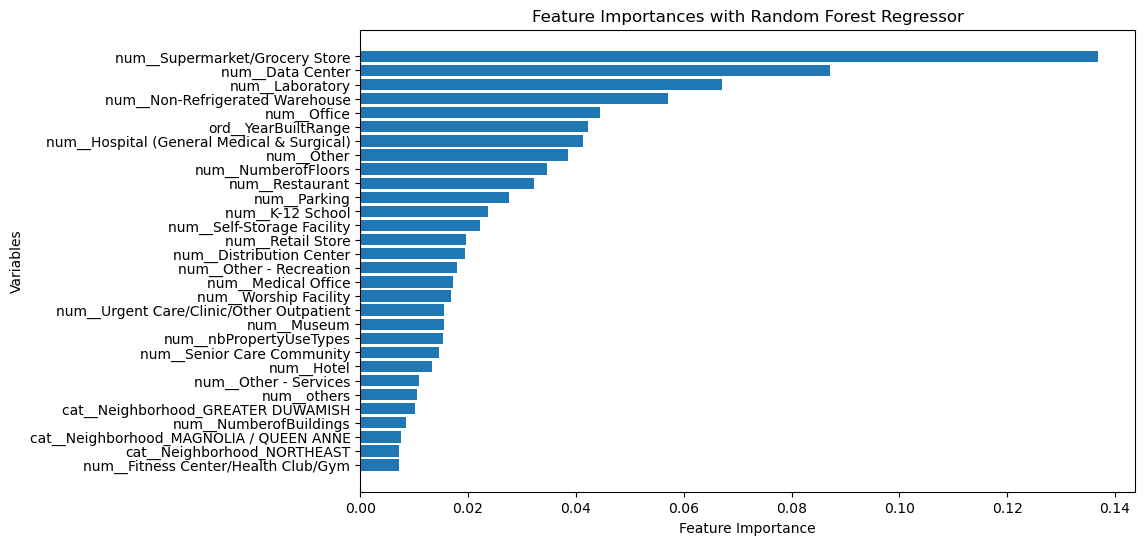

In [240]:
N = 30 # Nombre de variables à afficher
idx = np.argsort(importances)[-N:] # Sélectionner les N indices des variables les plus importantes
importances_top = importances[idx] # Sélectionner les Feature Importances des variables les plus importantes
variables_top = preprocessor_oneHotProcessed.get_feature_names_out()[idx] # Sélectionner les étiquettes des variables les plus importantes

plt.figure(figsize=(10, 6))
plt.barh(variables_top, importances_top, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Variables')
plt.title('Feature Importances with Random Forest Regressor')
plt.show()

# Ajout energy star

In [274]:
X_train, X_valid, y_train, y_valid = train_test_split(X_starOneHotProcessed, y_energySurf, test_size=0.2)

In [275]:
clf = Pipeline(steps=[('preprocessor', preprocessor_oneHotProcessed),
                      #('feature_selection', rfe),
                      ('model', RandomForestRegressor(bootstrap=False, 
                                                     n_estimators=50, 
                                                     criterion='absolute_error', 
                                                     max_depth=None,
                                                     max_features=20,
                                                     min_samples_split=20,
                                                      min_weight_fraction_leaf=0,
                                                     ))
                     ])

In [277]:
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
randfor_preds = clf.predict(X_valid)

print_model_score(get_model_score(y_valid, randfor_preds))

{'mae': 29.223251585529095,
 'rmse': 52.85366476555652,
 'r2': 0.48493811573908807,
 'rss': 921858.2601194443}

#### Amélioration avec kfold

In [279]:
# Perform 5-fold cross-validation for each scoring metric
mae_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=mae_scorer)
rmse_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=rmse_scorer)
rss_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=rss_scorer)
r2_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring=r2_scorer)

# Print the mean score and the score for each split for each metric
for metric, scores in zip(['MAE', 'RMSE', 'RSS', 'R^2'], [mae_scores, rmse_scores, rss_scores, r2_scores]):
    if metric == 'R^2':
        print(f"\n{metric} mean score: {scores.mean():.2f}")
    else:
        print(f"\n{metric} mean score: {-scores.mean():.2f}")
    print(f"{metric} scores for each split:")
    for i, score in enumerate(scores):
        if metric == 'R^2':
            print(f"Split {i+1}: {score:.2f}")
        else:
            print(f"Split {i+1}: {-score:.2f}")


MAE mean score: 32.25
MAE scores for each split:
Split 1: 35.38
Split 2: 36.14
Split 3: 29.66
Split 4: 30.38
Split 5: 29.68

RMSE mean score: 57.37
RMSE scores for each split:
Split 1: 66.31
Split 2: 66.96
Split 3: 50.24
Split 4: 48.98
Split 5: 54.38

RSS mean score: 3314.84
RSS scores for each split:
Split 1: 4221.05
Split 2: 4459.52
Split 3: 2562.33
Split 4: 2382.20
Split 5: 2949.08

R^2 mean score: 0.36
R^2 scores for each split:
Split 1: 0.04
Split 2: 0.45
Split 3: 0.38
Split 4: 0.55
Split 5: 0.40


#### Feature importance

In [280]:
rf_reg = clf.named_steps['model']
importances = rf_reg.feature_importances_

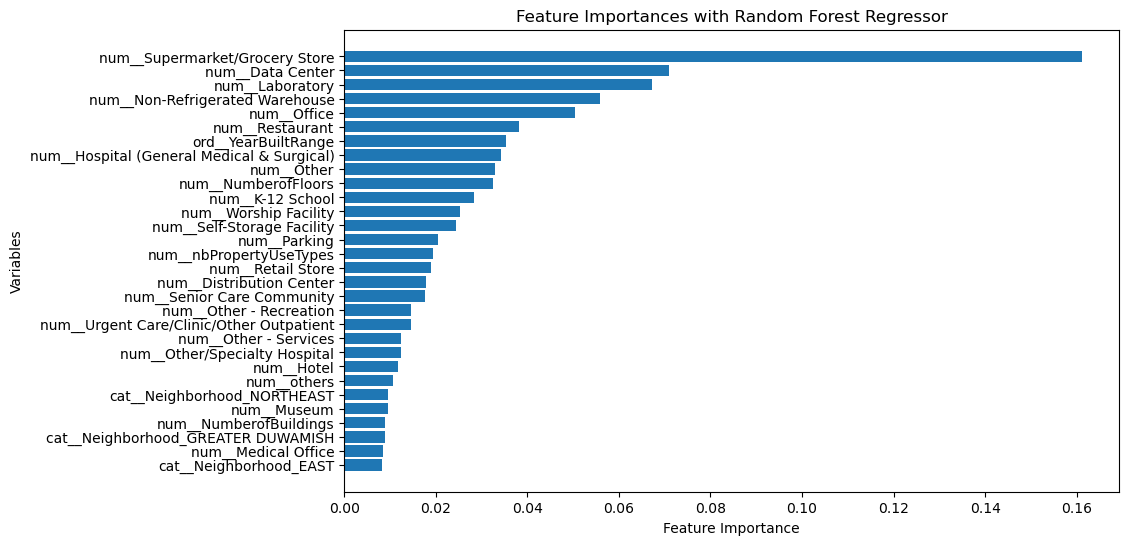

In [281]:
N = 30 # Nombre de variables à afficher
idx = np.argsort(importances)[-N:] # Sélectionner les N indices des variables les plus importantes
importances_top = importances[idx] # Sélectionner les Feature Importances des variables les plus importantes
variables_top = preprocessor_oneHotProcessed.get_feature_names_out()[idx] # Sélectionner les étiquettes des variables les plus importantes

plt.figure(figsize=(10, 6))
plt.barh(variables_top, importances_top, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Variables')
plt.title('Feature Importances with Random Forest Regressor')
plt.show()

# Solution proposée
Le type d'usage de bâtiment est la feature la plus importante ce qui est logique d'un point de vue métier.
Les variables du nombre d'étages ou de bâtiments sont intimement correlés à la surface.
La période de construction du bâtiment et la localisation peuvent faire varier les émissions de GES indépendament de la surface.

Je propose un modèle par type de bâtiment qui prend toutes les features proposées plus haut ainsi que la surface (sauf le type d'usage du bâtiment).
Chaque modèle prédit la consommation électrique.

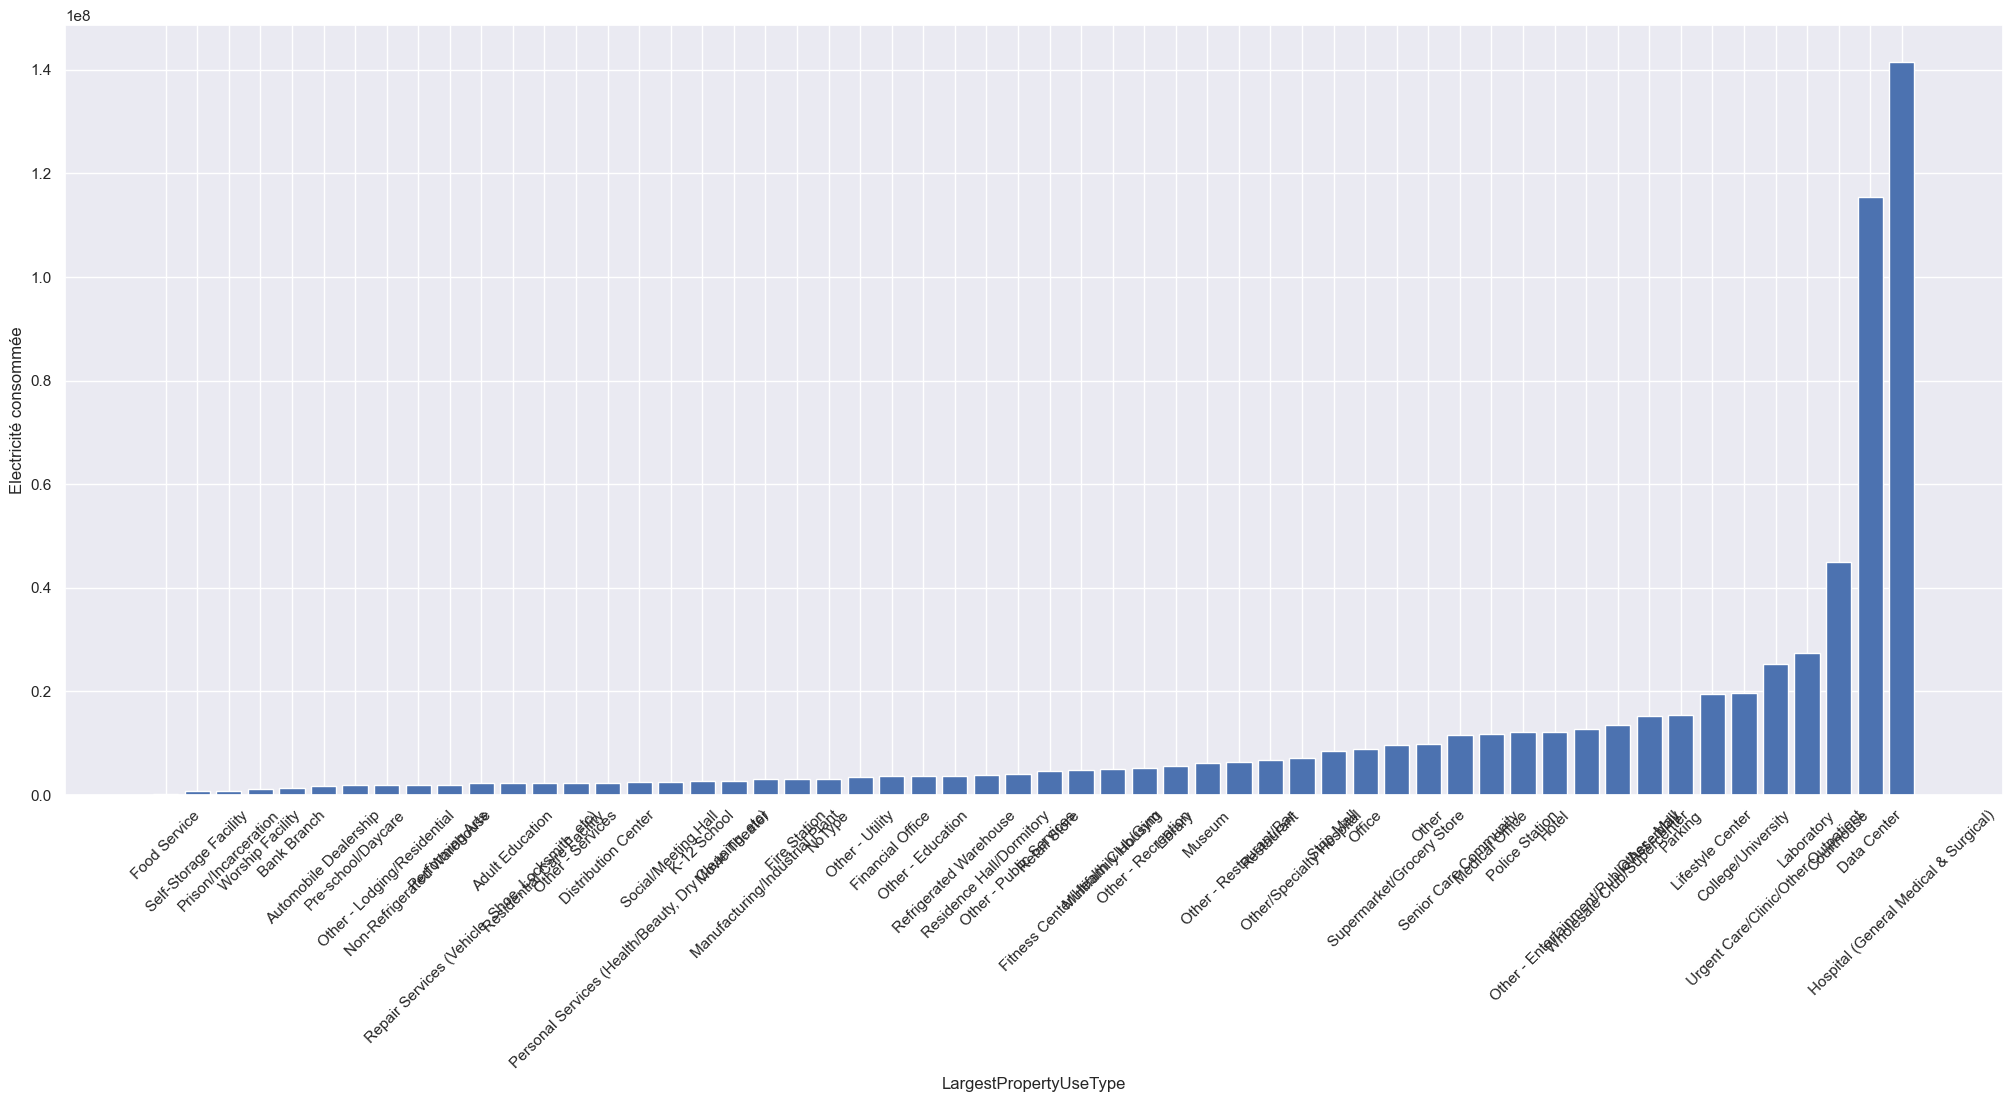

In [75]:
# Supposons que 'final_data' est votre DataFrame et 'LargestPropertyUseType' et 'elec' sont vos colonnes
elec_properties = final_data.groupby(['LargestPropertyUseType'])['elec'].mean().sort_values()

plt.figure(figsize=(25, 10))

plt.bar(elec_properties.index, elec_properties.values)
plt.ylabel('Electricité consommée')
plt.xlabel('LargestPropertyUseType')
plt.xticks(rotation=45)
plt.show()